In [2]:
import numpy as np
import numpy.fft as fp
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal as sg
import imtools

In [3]:
def norm(ar):
    return 255. * np.absolute(ar) / np.max(ar)

def save_as_img(ar, fname):
    Image.fromarray(ar.round().astype(np.uint8)).save(fname)
    
def gaussian_kernel(n, std, normalised=False):
    '''
    Generates a n x n matrix with a centered gaussian 
    of standard deviation std centered on it. If normalised,
    its volume equals 1.
    '''
    gaussian1D = sg.gaussian(n, std)
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    
    if normalised:
        gaussian2D /= (2*np.pi*(std**2))
        
    return gaussian2D



In [4]:
def get_points(response, min_dist = 10, threshold_percent = 0.1):
    """
    Return corners from a Harris response image
    min_dist ist the minumum number of pixels sperating corners
    and image boundary.
    """
    
    # find top corner caditades above a threshold
    threshold = response.max() * threshold_percent
    response_threshold = imtools.threshold(response, threshold)

    # get coordinates of candidates
    coords = np.array(response_threshold.nonzero()).T
    
    # ... and their values
    candidate_values = [response[c[0], c[1]] for c in coords]
    
    # sort candidates
    index = np.argsort(candidate_values)
    
    # store allowed point locations in array
    allowed_locations = np.zeros(response.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    
    # select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0], coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                             (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

In [5]:
def plot_points(image, filtered_coords, save=False):
    """
    Plots corners found in image
    """
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], 'r*')
    plt.axis('off')
    plt.title('edge points')
    if save:
        plt.savefig('result_images/edge_points.jpg')

In [6]:
file = 'test_images/bearing_scrached_fuji_tunnel.jpg'
img = Image.open(file).convert('L')
#img.thumbnail((300,300))
img = np.array(img)

(<matplotlib.image.AxesImage at 0x7f9712def240>, (-0.5, 773.5, 772.5, -0.5))

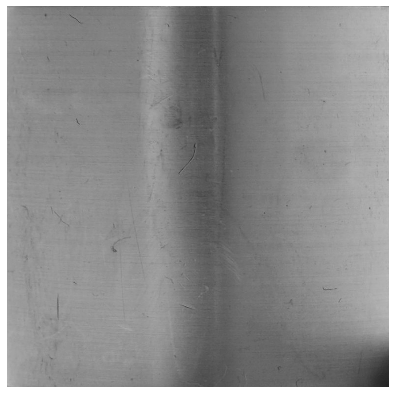

In [7]:
plt.figure(figsize=((7,7)))
plt.imshow(img, cmap='gray', vmin=0, vmax=255), plt.axis('off')

### Gaussian Blur

In [15]:
#gauss = gaussian_kernel(3, 0.84089642, normalised=True)
gauss = gaussian_kernel(40, 10, normalised=False)

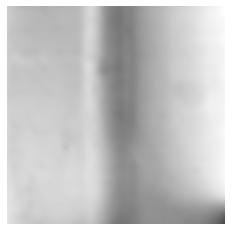

In [16]:
blurred_img = sg.convolve(gauss, img, 'valid')
plt.imshow(norm(blurred_img), cmap='gray', vmin=0, vmax=255), plt.axis('off')
save_as_img(norm(blurred_img), 'result_images/brearing_gauss.jpg')

## Sobel Edge Detection

In [10]:
vert_edg = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])

horr_edg = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])

In [11]:
vert_edg_img = sg.convolve(vert_edg, blurred_img, 'valid')
horr_edg_img = sg.convolve(horr_edg, blurred_img, 'valid')
gradient_edg_img = np.sqrt(np.power(vert_edg_img, 2) + np.power(horr_edg_img, 2))
custom_gradient_edg_img = np.sqrt(np.power(vert_edg_img*0.1, 2) + np.power(horr_edg_img, 2))

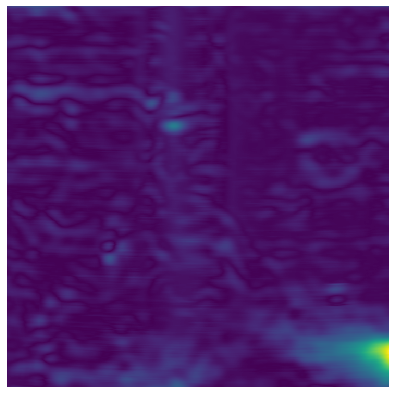

In [12]:
plt.figure(figsize=((7,7)))
#plt.imshow(norm(gradient_edg_img)), plt.axis('off')
plt.imshow(norm(custom_gradient_edg_img)), plt.axis('off')
#save_as_img(norm(gradient_edg_img), 'result_images/brearing_edge.jpg')
save_as_img(norm(custom_gradient_edg_img), 'result_images/brearing_edge.jpg')

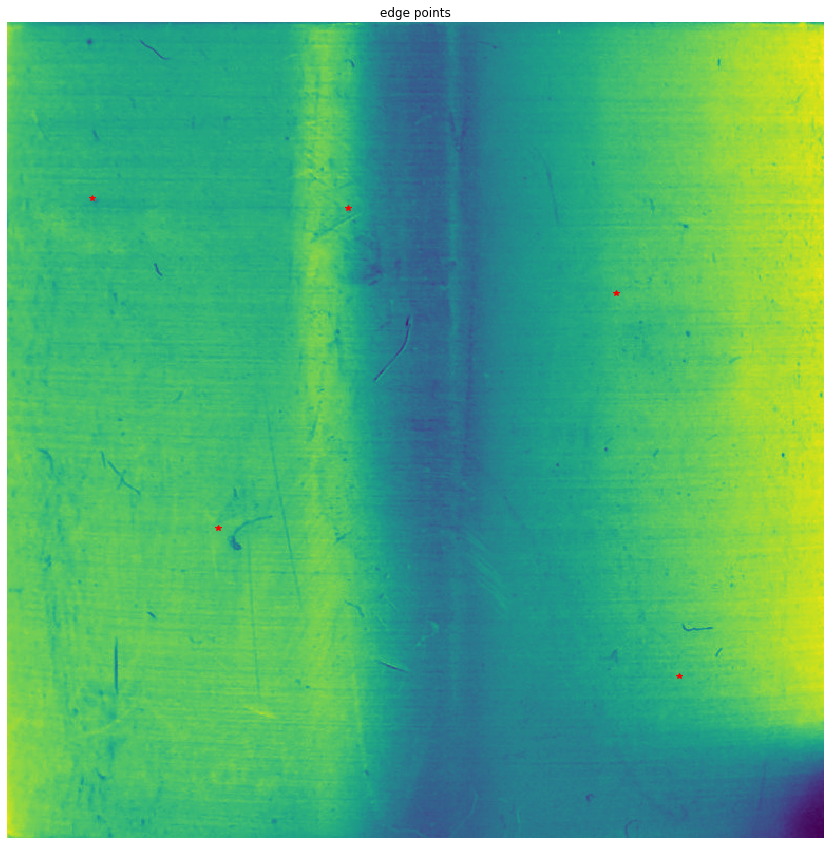

In [13]:
points = get_points(custom_gradient_edg_img, min_dist=80, threshold_percent=0.2)
plot_points(img, points, save=True)
